# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (679 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.24.4
    Uninstalling protobuf-4.24.4:
      Successfully uninstalled protobuf-4.24.4


In [1]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [3]:
# Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2024-12-20 14:35:20--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.221.24, 52.219.193.128, 52.219.193.24, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.221.24|:443... connected.
ERROR: cannot verify s3-us-west-1.amazonaws.com's certificate, issued by ‘CN=Amazon RSA 2048 M01,O=Amazon,C=US’:
  Unable to locally verify the issuer's authority.
To connect to s3-us-west-1.amazonaws.com insecurely, use `--no-check-certificate'.
unzip:  cannot find or open dogImages.zip, dogImages.zip.zip or dogImages.zip.ZIP.


## Hyperparameter Tuning
This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [15]:
# Declare your HP ranges, metrics etc.
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

role = sagemaker.get_execution_role()



In [26]:
#Create estimators for your HPs
from sagemaker.pytorch import PyTorch
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge"
)


hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.01),
    "batch-size": CategoricalParameter([32, 256]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

#Create your HyperparameterTuner Object
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [27]:
#  Fit your HP Tuner
tuner.fit(inputs={
    "train": "s3://sagemaker-studio-235376860436-zxoscygdhb/unzipped-files/dogImages/train/",
    "test": "s3://sagemaker-studio-235376860436-zxoscygdhb/unzipped-files/dogImages/test/"
},wait=True) #  Remember to include your data channels

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-241223-2128


...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [29]:
#  Get the best estimators and the best HPs
tuner.best_training_job()
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-12-23 22:25:45 Starting - Found matching resource for reuse
2024-12-23 22:25:45 Downloading - Downloading the training image
2024-12-23 22:25:45 Training - Training image download completed. Training in progress.
2024-12-23 22:25:45 Uploading - Uploading generated training model
2024-12-23 22:25:45 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'lr': '0.004948720638263103',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2024-12-23-21-28-13-370"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-235376860436/pytorch-training-2024-12-23-21-28-13-370/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [176]:
# Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, DebuggerHookConfig

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [177]:
#  Create and fit an estimator
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

import torchvision.datasets as datasets
hyperparameters = {"epochs": "5", "batch-size": "10", "test-batch-size": "10", "lr": "0.004"}

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="smdebugger-train-model",
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    profiler_config=profiler_config,
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config,
)
estimator.fit(inputs={
    "train": "s3://sagemaker-studio-235376860436-zxoscygdhb/unzipped-files/dogImages/train/",
    "test": "s3://sagemaker-studio-235376860436-zxoscygdhb/unzipped-files/dogImages/test/"
},wait=True)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.

2024-12-22 13:12:36 Starting - Starting the training job...
2024-12-22 13:13:06 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-12-22 13:13:26 Downloading - Downloading input data...
2024-12-22 13:14:06 Downloading - Downloading the training image...
2024-12-22 13:14:34 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-12-22 13:14:43,520 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-12-22 13:14:43,523 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-12-22 13:14:43,532 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-12-22 13:14:43,534 sagemaker_py

In [178]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [179]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2024-12-22 13:39:17.496 default:125 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-235376860436/smdebugger-train-model-2024-12-22-13-12-33-542/debug-output


In [180]:
trial.tensor_names()

['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [181]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

34

In [182]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

9

In [183]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


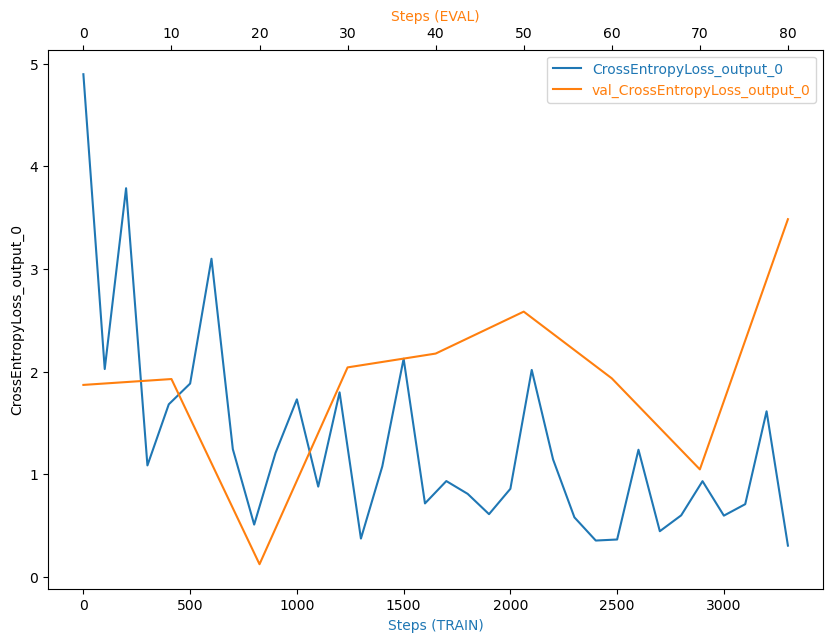

In [184]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [185]:
estimator.latest_training_job.job_name

'smdebugger-train-model-2024-12-22-13-12-33-542'

In [186]:
#  Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"


In [187]:
! aws s3 ls {rule_output_path} --recursive

2024-12-22 13:38:49     386532 smdebugger-train-model-2024-12-22-13-12-33-542/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-12-22 13:38:48     236573 smdebugger-train-model-2024-12-22-13-12-33-542/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-12-22 13:38:44        192 smdebugger-train-model-2024-12-22-13-12-33-542/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-12-22 13:38:44        200 smdebugger-train-model-2024-12-22-13-12-33-542/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-12-22 13:38:44       1909 smdebugger-train-model-2024-12-22-13-12-33-542/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-12-22 13:38:44        127 smdebugger-train-model-2024-12-22-13-12-33-542/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-12-22 13:38:44        199 smdebugger-train-model-2024-12-22-13-12-33-542/rule-output/

In [188]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-235376860436/smdebugger-train-model-2024-12-22-13-12-33-542/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-235376860436/smdebugger-train-model-2024-12-22-13-12-33-542/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-235376860436/smdebugger-train-model-2024-12-22-13-12-33-542/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-235376860436/smdebugger-train-model-2024-12-22-13-12-33-542/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-235376860436/smdebu

In [193]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
 

In [197]:
import shutil

# Define the source and destination paths
source_path = profiler_report_name + "/profiler-output/profiler-report.html"
destination_path = "profiler-report.html"

# Copy the file from the source to the destination
shutil.copyfile(source_path, destination_path)
print(f"Profiler report saved to {destination_path}")


Profiler report saved to profiler-report.html


In [194]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [30]:
predictor = tuner.deploy(initial_instance_count=1, instance_type="ml.t2.medium")


2024-12-23 22:25:45 Starting - Found matching resource for reuse
2024-12-23 22:25:45 Downloading - Downloading the training image
2024-12-23 22:25:45 Training - Training image download completed. Training in progress.
2024-12-23 22:25:45 Uploading - Uploading generated training model
2024-12-23 22:25:45 Completed - Resource released due to keep alive period expiry

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-235376860436/pytorch-training-241223-2128-004-7296b3ce/output/model.tar.gz), script artifact (s3://sagemaker-us-east-1-235376860436/pytorch-training-2024-12-23-21-28-13-370/source/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-235376860436/pytorch-training-2024-12-23-22-32-12-167/model.tar.gz. This may take some time depending on model size...


INFO:sagemaker:Creating model with name: pytorch-training-2024-12-23-22-32-12-167
INFO:sagemaker:Creating endpoint-config with name pytorch-training-241223-2128-004-7296b3ce
INFO:sagemaker:Creating endpoint with name pytorch-training-241223-2128-004-7296b3ce


--------------!

In [35]:
from sagemaker.pytorch import PyTorchModel

model = PyTorchModel(
    model_data="s3://sagemaker-us-east-1-235376860436/pytorch-training-241223-2128-004-7296b3ce/output/model.tar.gz",
    role=role,
    entry_point="inference.py",
    framework_version="1.8",
    py_version="py36"
)

predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.c5.large"  # CPU-based instance
)


INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-235376860436/pytorch-training-241223-2128-004-7296b3ce/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-235376860436/pytorch-inference-2024-12-23-22-57-32-063/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-12-23-22-57-36-212
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-12-23-22-57-36-946
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-12-23-22-57-36-946


-------!

In [37]:


 
from PIL import Image
import io

# Load an image
with open("Affenpinscher_00038.jpg", "rb") as f:
    image_bytes = f.read()

# Send a prediction request
response = predictor.predict(image_bytes, initial_args={"ContentType": "image/jpeg"})
print("Prediction response:", response)



ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from primary with message "name 'io' is not defined
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/sagemaker_inference/transformer.py", line 126, in transform
    result = self._transform_fn(self._model, input_data, content_type, accept)
  File "/opt/conda/lib/python3.6/site-packages/sagemaker_inference/transformer.py", line 215, in _default_transform_fn
    data = self._input_fn(input_data, content_type)
  File "/opt/ml/model/code/inference.py", line 20, in input_fn
    image = Image.open(io.BytesIO(request_body))
NameError: name 'io' is not defined
". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2024-12-23-22-57-36-946 in account 235376860436 for more information.

In [38]:
#  Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-12-23-22-57-36-946
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-12-23-22-57-36-946
